# Welcome to the Epic 7 Gear OCR Processer Tutorial!

This is mainly for those who were asking about what process I was originally using when I didn't have machine learning model training or reading by screen recording implemented. This method still does definitely work pretty well, even faster (albeit at much lower accuracy), but I hope you can learn from messing around with this notebook. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from PIL import Image

import pytesseract
from pytesseract import image_to_string

%matplotlib inline

This is just a helper function for displaying our images in this example. In the actual program, we don't need to actually see any of these images.

In [2]:
def display_example(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Background

So many there are many great Epic Seven gear optimizers out there already like [u/HyrTheWinter's popular one ](https://eseo-8a854.firebaseapp.com/) or [this more recent Windows application one](https://github.com/Zarroc2762/E7-Gear-Optimizer/releases).

As great as all of these tools are, plugging in even a subset of equipment is for me at least a really annoying part for me. So when I found out about [Tesseract](https://github.com/tesseract-ocr/tesseract), I figured it wouldn't be too hard to turn screenshots of equipment into JSON format that could be much more easily imported into those optimizers.

But either way, here we go. This is an example of our starting image that we'd pull in from the `screenshots` folder.

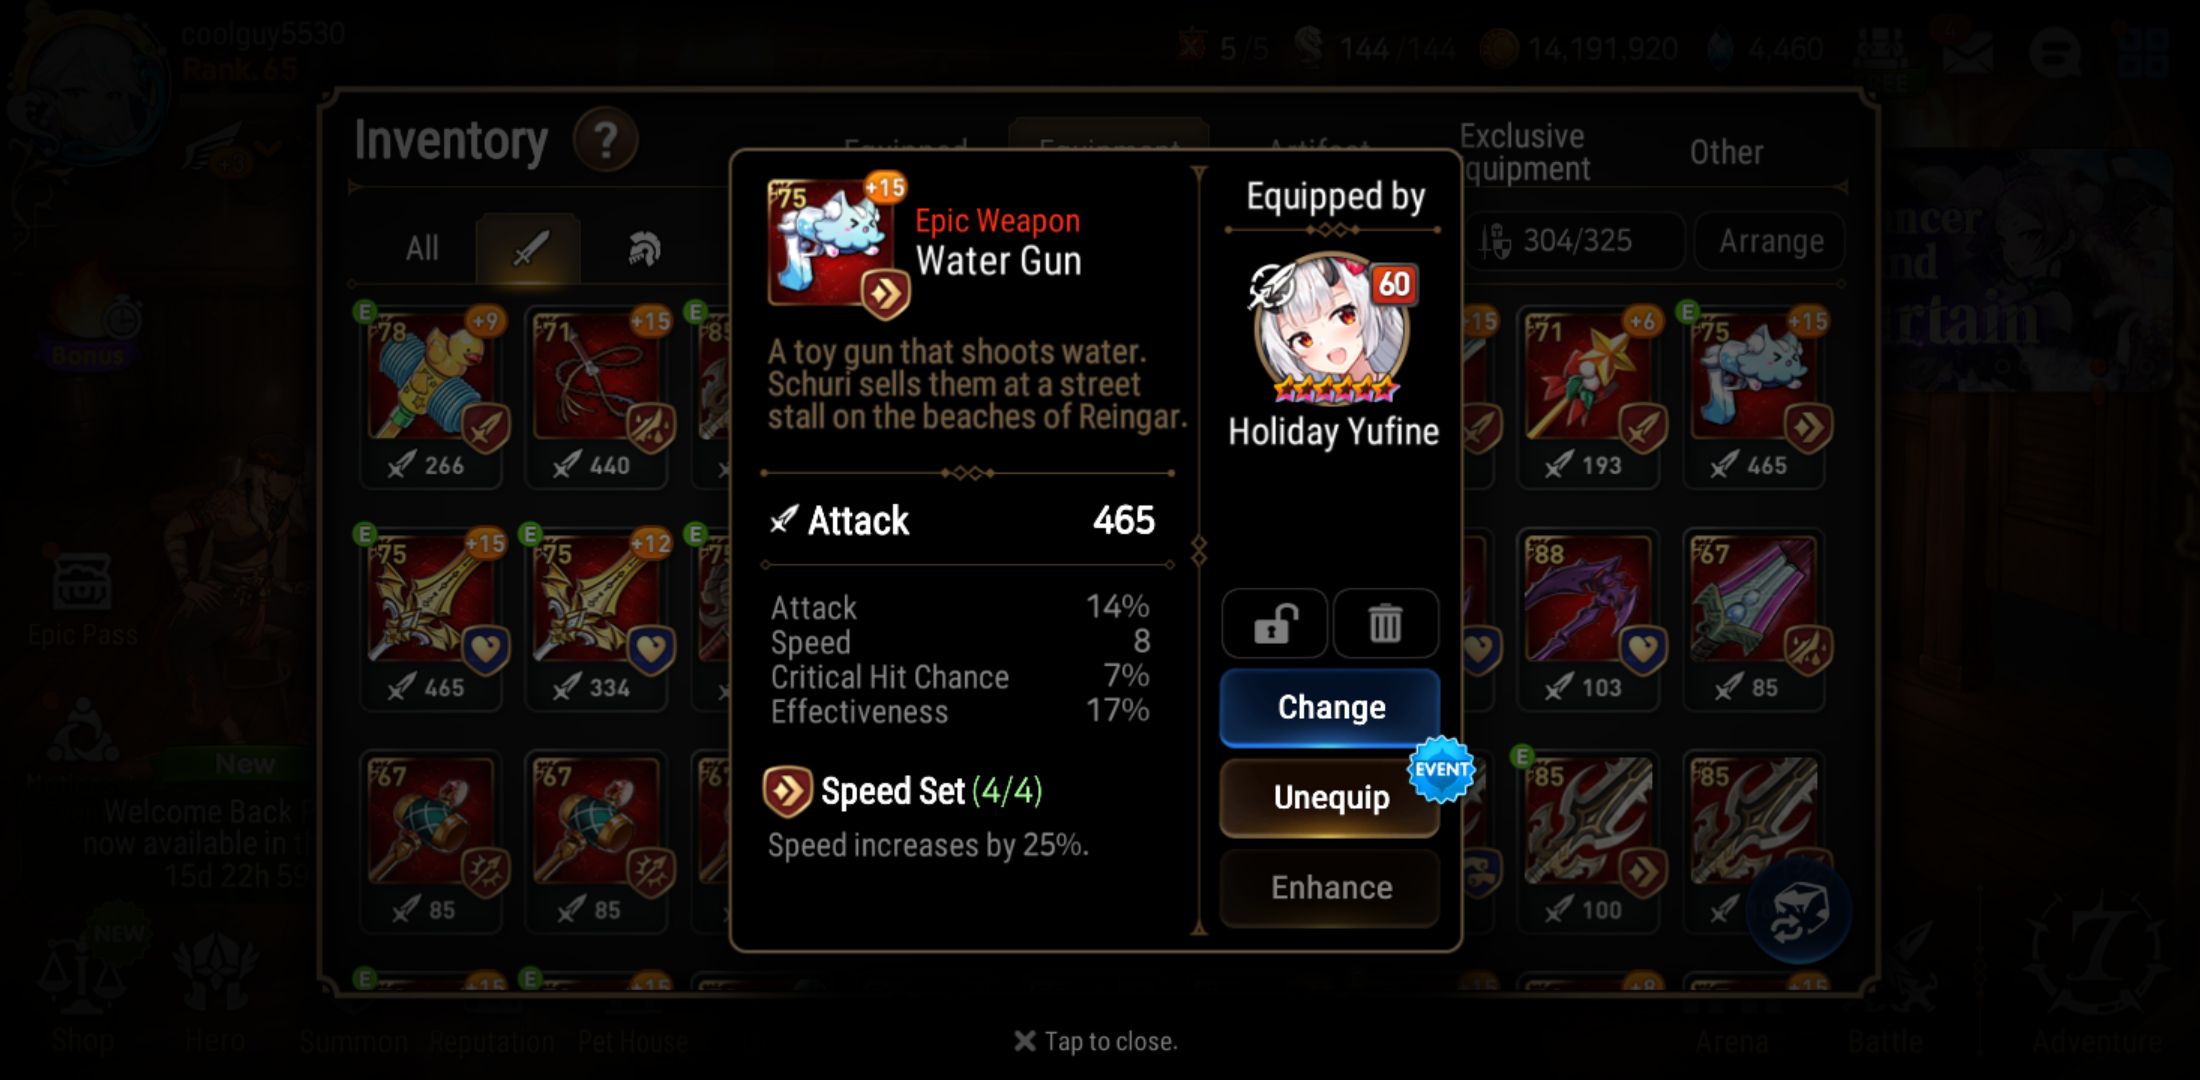

So how do we parse this image? There are two places of information we need:

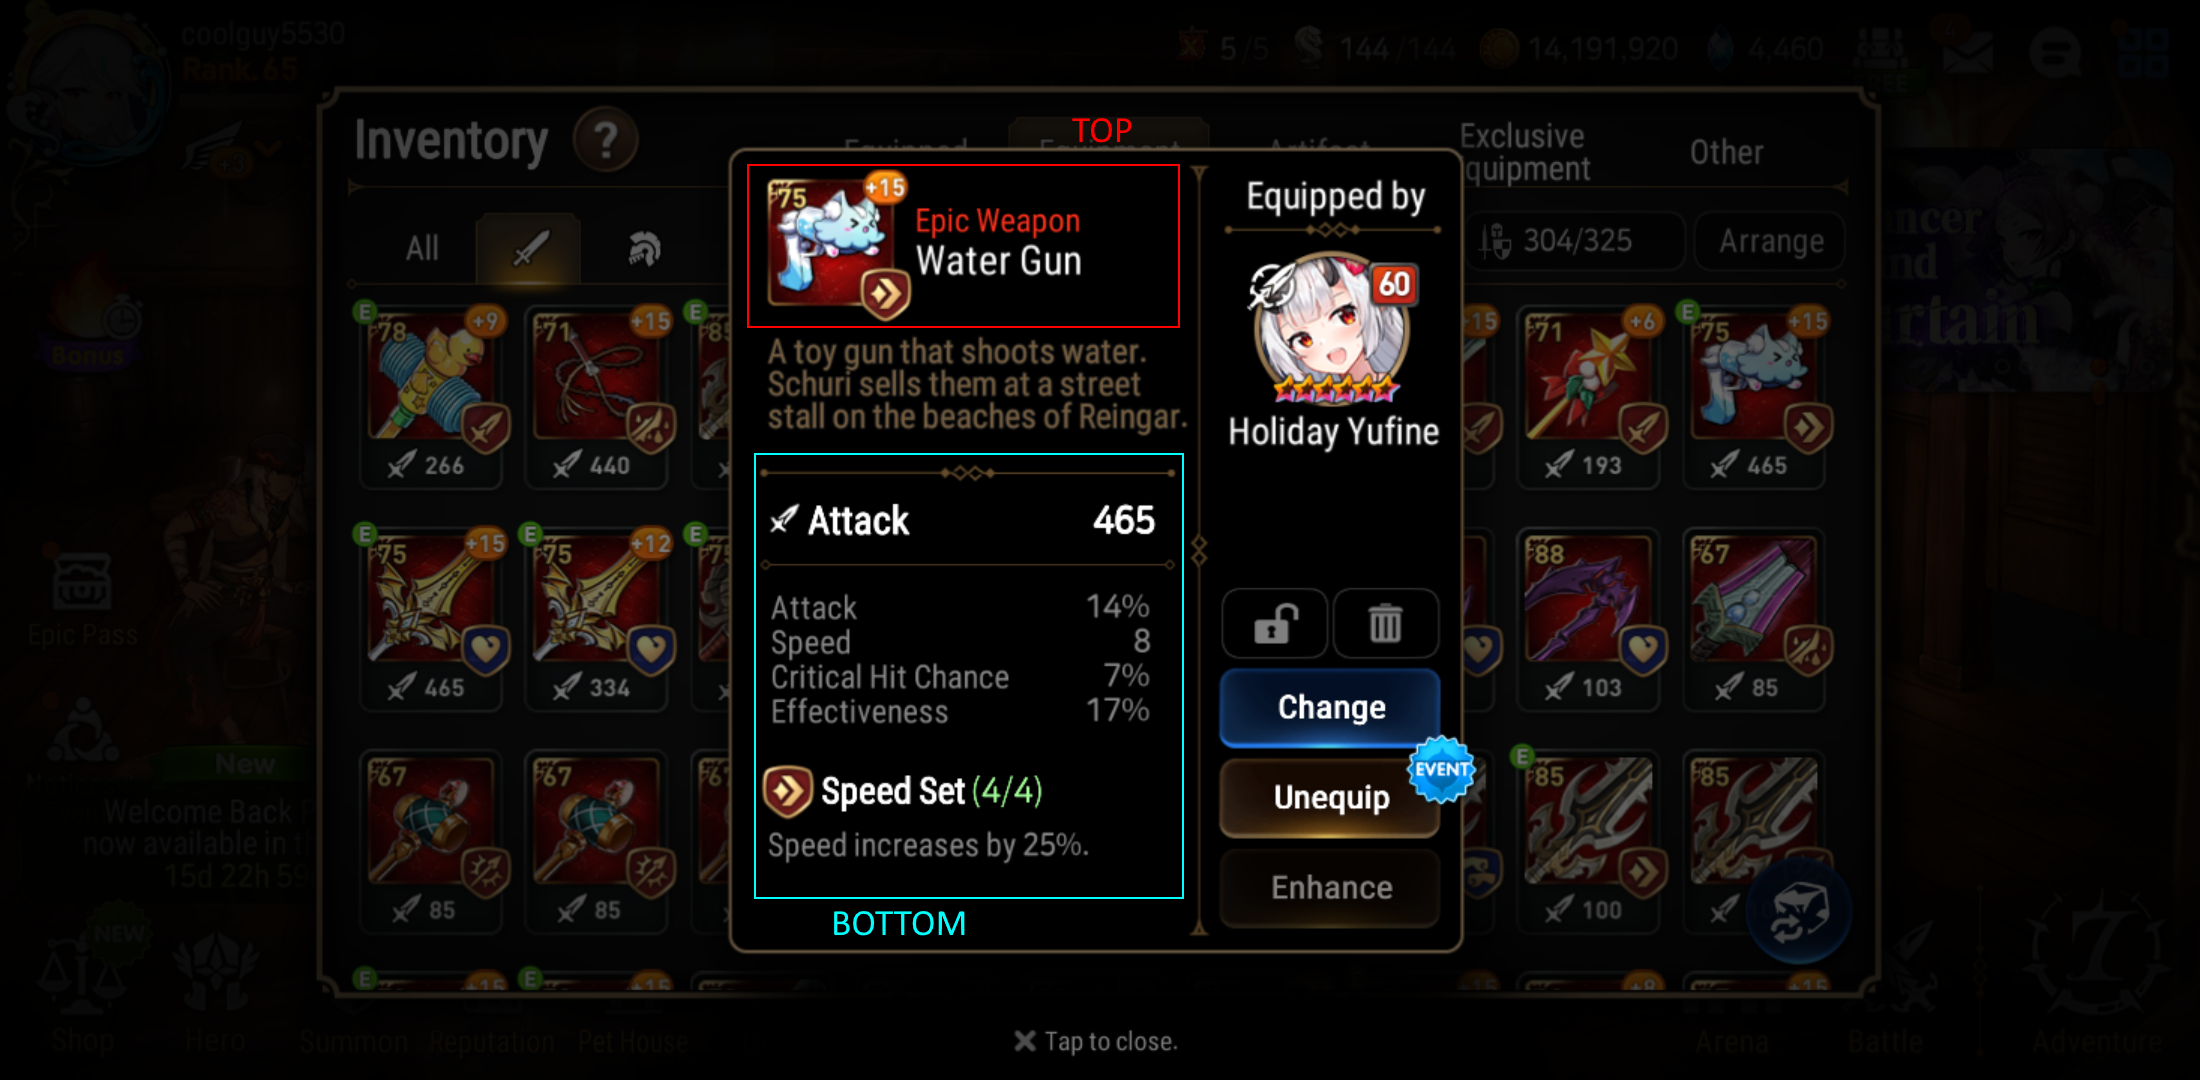

Now, we could simply get each part based on position. This would make the image resolution irrelevant to the process (which is nice because you would not have to change your resolution just for the screenshots).

However, there's a really annoying detail. 

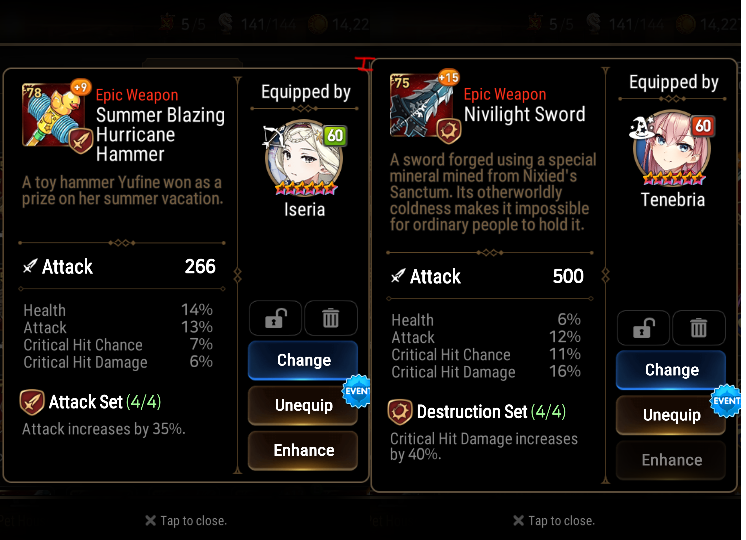

I hadn't really noticed this before, but apparently the equipment description boxes have varying height based on the length of the description/flavor text, and even how many lines the set description takes up.

For those reasons, we do actually have to enforce a 2200x1080 resolution so that we can go with Plan B: [template matching](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html).

You can read a lot more in detail about what template matching is exactly, but the basic concept is pretty simple and neat: it just allows you to find the position an image inside a larger image. You might already be able to see how that can be useful in OCR-ing these kinds of images.

So what are we going to template match? Well have a look at this picture:

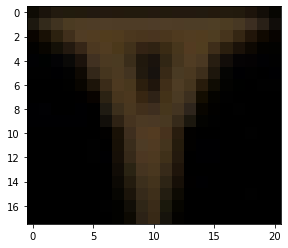

In [3]:
top_decoration = cv2.imread('e7/top.jpg')
display_example(top_decoration)

Recognize that? It's actually a tiny little decorative triangle thingy on that equipment screen:

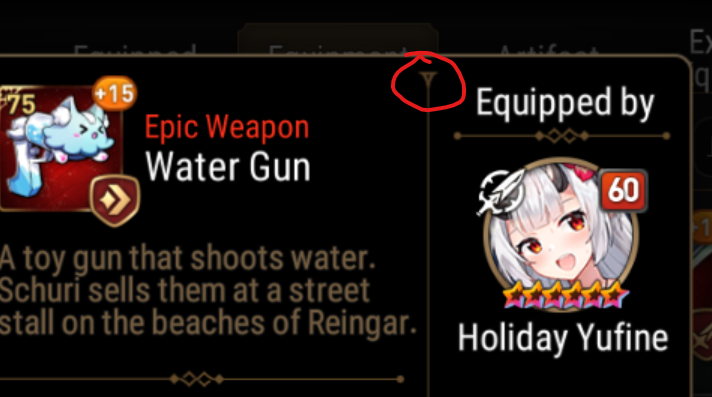

This is actually what we'll be using to template match. It may seem a bit tiny to rely on, but the screenshots should all be very consistent, and it's position relative to the weapon type and set should be constant.

So this is actually the exact thing that requires the resolution to be enforced at 2200x1080, because changing that distorts what the triangle looks like, so CV2 starts trying to match up the triangle to some random other points on the image.

Either way, let's see what we can do with this technique.

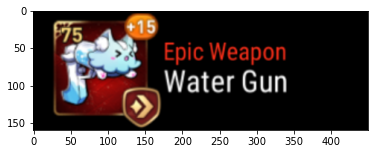

In [4]:
# load in our screenshot
img = cv2.imread('screenshots/Screenshot_2020-10-25-22-50-43.png')

# Top box
top_decoration = cv2.imread('e7/top.jpg',0)
a, b, c, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), top_decoration, cv2.TM_CCOEFF_NORMED))
top_box = img[max_loc[1]:max_loc[1]+160,740:1190] # Fixed width, then crop 160 pixels from top triangle
display_example(top_box)

Looks pretty good. In a nutshell, the lines above
1. Read in the image
2. Use the template matching to get the get the height of the triangle
3. We just have to now crop out a fixed portion of the image

Those cropping dimensions are just constant because we know the resolution will be the same always, and unlike the height, the width of the equipment display box is constant. 

Now for the bottom portion. We use the divider in the middle here as our template to match.

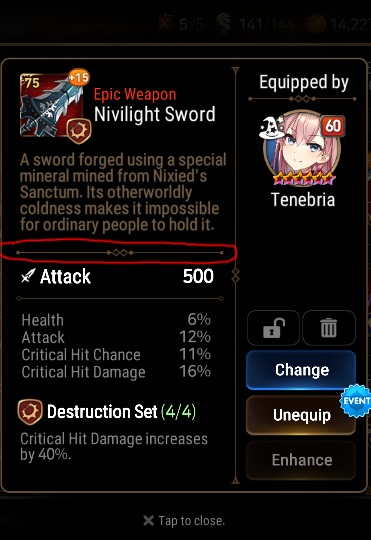

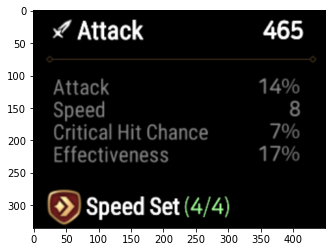

In [5]:
bottom_decoration = cv2.imread('e7/bottom.jpg',0)
a, b, c, max_loc = cv2.minMaxLoc(cv2.matchTemplate(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), bottom_decoration, cv2.TM_CCOEFF_NORMED))
bottom_box = img[max_loc[1]+25:max_loc[1]+360,740:1190] # Fixed width, shift down 25 from divider, then crop 335 pixels deep
display_example(bottom_box)

Almost the same thing here. The main difference is that the vertical cropping dimensions are a bit different because we want to get everything below that divider, so we start 25 pixels below where we found it. The width doesn't have to change.

# Cropping the Important Parts

Now that we've cropped out all the extranous parts of the image, we need to get into the meat and potatoes: getting all the data about this piece of equipment. To that that, we have to crop even more specific parts of each of these top and bottom sections.

In fact, again taking advantage of the constant resolution of our images, we can just find these numbers manually/experimentally, and thanks to our template matching work, these should work for any image we throw in.

Let's start with what we can get from that top section: type/slot, level, and enhance level.

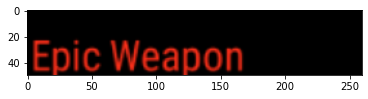

In [6]:
equipment_type = top_box[20:70,172:432]
display_example(equipment_type)

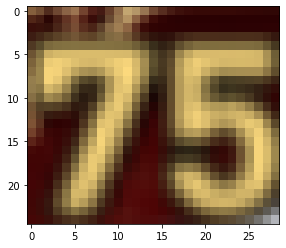

In [7]:
equipment_level = top_box[19:44,37:66]
display_example(equipment_level)

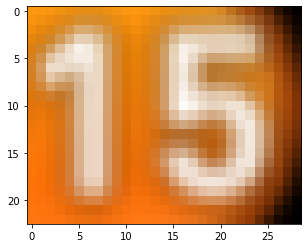

In [8]:
equipment_enhance_lvl = top_box[11:34,139:168]
display_example(equipment_enhance_lvl)

A couple comments:
- The weapon type image has a little blank space just in case the rarity+type is really long like "Normal Necklace"
- Those numbers have a lot of noise, so that's something we're going to have to keep in mind for when we actually process and OCR these images

But now for the stuff we can get from the bottom: main stat, substats, and set.

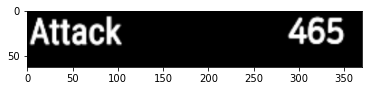

In [9]:
equipment_main_stat = bottom_box[8:70,65:435]
display_example(equipment_main_stat)

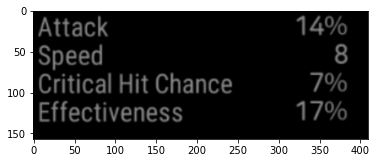

In [10]:
equipment_substats = bottom_box[98:255,25:435]
display_example(equipment_substats)

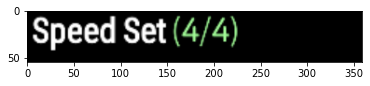

In [11]:
equipment_set = bottom_box[280:340,76:435]
display_example(equipment_set)

So now we *actually* have all the important pieces we need separated out. It's time to get OCR-ing!

# OCR

This first cell is mostly just setup to use Tesseract.

In [12]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'
TESSDATA_PREFIX = r'C:\Program Files\Tesseract-OCR'

In [13]:
def process_image(img, display=False):
    thresh = cv2.THRESH_BINARY_INV
    thresh_low = 70
    proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0, 0), fx=5, fy=5), cv2.COLOR_BGR2GRAY), thresh_low, 255, thresh)[1], 3), cv2.COLOR_GRAY2RGB)
    if display:
        display_example(proc)
    data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 6').replace('Rina','Ring').replace('Edic','Epic').replace('Enic','Epic')
    return data

So what does the function do? Let's start with Line 4, which is probably the most complicated line, but it's mostly just standard image preprocessing. We
1. Blow up the image with `resize` by a factor of 5
2. Convert the image to grayscale
3. Threshold the image (basically just turns lighter parts solid black and darker parts solid white, helps contrast text with background
4. Use Tesseract's `image_to_string` to turn the image text into a string. (I have it manually check for common errors "Rina" instead of "Ring" and "Edic" instead of "Epic", which happens a bit because of cropping off tiny bits of letter I'm suspecting. This happens in various other parts of the OCR process. Luckily it's a bit predictable because the font is consistent.)

I also have it print the image right before Tesseract reads it in case your curious.

Let's see how it works.

'Epic Weapon\n\x0c'

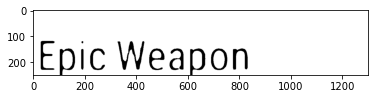

In [14]:
process_image(equipment_type, display=True)

'Attack 465\n\x0c'

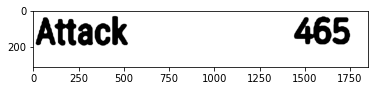

In [15]:
process_image(equipment_main_stat, display=True)

'Attack 14%\nSpeed 8\nCritical Hit Chance 7%\nEffectiveness 17%\n\x0c'

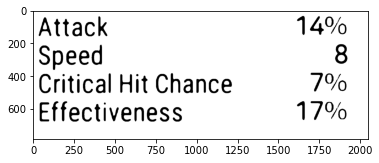

In [16]:
process_image(equipment_substats, display=True)

'Speed Set (4/4)\n\x0c'

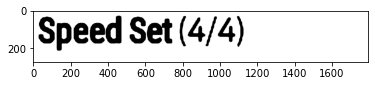

In [17]:
process_image(equipment_set, display=True)

Looks pretty good. The only thing we have to be careful about is the fact that for some reason Tesseract is giving us a weird string at the end that looks like "\n\x0c". I don't really know what it is, but it's not too hard to filter out in the end.

Either way, the astute may realize I'm dodging the equipment level and enhance level, which are the two numbers with a lot of background noise I mentioned we were going to have to be careful about. If I try the method as it stands on those numbers:

'\x0c'

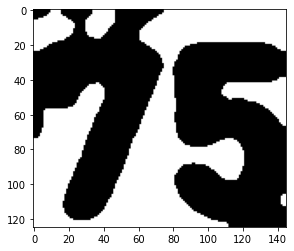

In [18]:
process_image(equipment_level, display=True)

')\n\x0c'

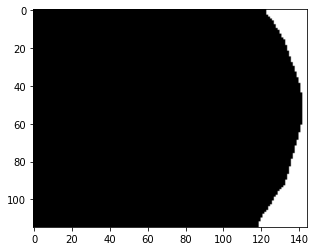

In [19]:
process_image(equipment_enhance_lvl, display=True)

The results are pretty bad. Especially the enhance level, where both the number were after and the background were bright enough to both be converted to complete black. In other words, we're going to need to adjust the thresholding process to make sure the text contrasts its background well enough.

In [20]:
def special_process(img, display=False):
    thresh = cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU
    thresh_low = 81
    proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0, 0), fx=5, fy=5), cv2.COLOR_RGB2GRAY), thresh_low, 255, thresh)[1], 3), cv2.COLOR_GRAY2RGB)
    data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 7').replace('+b','6').replace('>','0')
    if not any(i.isdigit() for i in data):
        thresh_low = 100
        proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0, 0), fx=5, fy=5), cv2.COLOR_RGB2GRAY), thresh_low, 255, thresh)[1], 3), cv2.COLOR_GRAY2RGB)
        data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 7').replace('+b','6').replace('>','0')
        if not any(i.isdigit() for i in data):
            thresh_low = 125
            proc = cv2.cvtColor(cv2.medianBlur(cv2.threshold(cv2.cvtColor(cv2.resize(img, (0, 0), fx=5, fy=5), cv2.COLOR_RGB2GRAY), thresh_low, 255, thresh)[1], 3), cv2.COLOR_GRAY2RGB)
            data = image_to_string(Image.fromarray(proc), lang='eng', config='--psm 7').replace('+b','6').replace('>','0')
            if not any(i.isdigit() for i in data):
                data = str(0)
    if display:
        display_example(proc)
    return data

So what's going on here? 

First off, notice we now have `thresh = cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU` rather than just `cv2.THRESH_BINARY_INV`. You can read more about what exactly this means [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html) (trust me, it's actually kind of interesting if you're into that mathy stuff), but just know that this kind of thresholding handles noisy images a lot better than just binary (either a pixel is or isn't bright enough).

And the rest is the same as the normal processing function, just repeated a few times. We're basically just trying our process three times, each with a different `thresh_low` value for the `threshold` process, which controls how bright (white) pixels have to be in order to be switched to black. 

We don't want to immediately use the highest value because this could be too high, and we'd lose parts of the number without trying lower values.

'15\n\x0c'

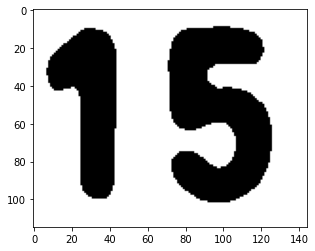

In [21]:
special_process(equipment_enhance_lvl, display=True)

'75\n\x0c'

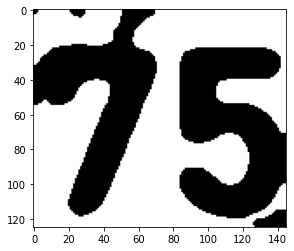

In [22]:
special_process(equipment_level, display=True)

As you can see, the processed images look better (especially the enhance level one), and the function spit out the right numbers. 

And now we're bascially done with the image part of the process, we've shown that we can extract all the info we need with the functions defined above. All that's left is translating this info into the proper format.

# Cleaning and Formatting

In [23]:
item = {
    'locked':False,              # these are just here for the purposes of matching the import format,
    'efficiency':0,              # we won't be changing them
    'rarity': '',                # Normal, Epic, Legendary, etc.
    'slot': '',                  # Weapon, Armor, Boots, etc
    'level': 0,
    'ability': 0,                # enhance level, naming convention just matches what the Gear Optimizers take
    'mainStat': ['', 0],         # [Stat, amount].
#  For percent stats, the number is just the percentage, e.g. Attack 10% becomes ['Attack',10]
#     'subStat1': ['', 0], 
#     'subStat2': ['', 0],       # we comment these out because technically not all equipment has substats,
#     'subStat3': ['', 0],       # but Python allows you to add keys on the fly anyway
#     'subStat4': ['', 0],
    'set': '',                   # Speed, Rage, Immunity, etc
    'id': ''
}

This is sort of the template dictionary we'll be using for each item, with naming conventions that with popular gear optimizers [like this one](https://github.com/Zarroc2762/E7-Gear-Optimizer) uses.

Let's start filling it.

For the purposes of parsing what's read from the images, we also want to define some helper functions.

In [24]:
def digit_filter(val):
    if not val: # if val is already 0
        return 0
    elif val == '.': # if val is just a dot, probably an artifact from incorrect OCR
        return 0
    else:
        return int(''.join(filter(str.isdigit,val)))
    # filter return an iterator full of the values in val that are digits
    # then they're all joined together and turned into a number
    
def char_filter(val):
    return ''.join(filter(str.isalpha,val)).capitalize()
    # filter return an iterator full of the values in val that are alphabetical characters
    # gets rid of random other characters/numbers that were accidentally detected

In [25]:
data = process_image(equipment_type)
# first word is the rarity, second is the category/slot
item['rarity'] = char_filter(data.split(' ')[0])
item['slot'] = char_filter(data.split(' ')[1].split('\n')[0])

In [26]:
data = special_process(equipment_level)
item['level'] = digit_filter(data.replace('S','5').replace('B','8').replace('a','8'))

In [27]:
data = special_process(equipment_enhance_lvl)
item['ability'] = digit_filter(data.replace('S','5').replace('B','8').replace('a','8'))

In [28]:
data = process_image(equipment_set)
item['set'] = char_filter(data.split(' Set')[0]) # The set type the word right before "Set"

Let's see where we're at now.

In [29]:
item

{'locked': False,
 'efficiency': 0,
 'rarity': 'Epic',
 'slot': 'Weapon',
 'level': 75,
 'ability': 15,
 'mainStat': ['', 0],
 'set': 'Speed',
 'id': ''}

# Stat Name Conversion for Main Stat and Substats

Looks pretty good so far. But I'm pausing here because the next ones are going to require a bit more work. This mainly comes from the fact that those gear optimizers use a shorthand system for stats, mostly to easily differentiate between whether a number is for a percentage stat or a flat stat.

| Stat                | Shorthand Form |
|---------------------|----------------|
| Attack              | Atk            |
| %Attack             | AtkP           |
| Health              | HP             |
| %Health             | HPP            |
| Defense             | Def            |
| %Defense            | DefP           |
| Speed               | Spd            |
| Critical Hit Chance | CChance        |
| Critical Hit Damage | CDmg           |
| Effectiveness       | Eff            |
| Effect Resistance   | Res            |

So we're actually going to need a function to convert the read-in text to this format.

In [30]:
def stat_converter(stat):
    result = ''
    if 'attack' in stat.lower():
        result = 'Atk'
        if '%' in stat:
            result += 'P'
    if 'health' in stat.lower():
        result = 'HP'
        if '%' in stat:
            result += 'P'
    if 'defense' in stat.lower():
        result = 'Def'
        if '%' in stat:
            result += 'P'
    if 'speed' in stat.lower():
        result = 'Spd'
    if 'chance' in stat.lower():
        result = 'CChance' # for a couple of these, just the a single word like "chance" uniquely identifies the stat
    if 'damage' in stat.lower():
        result = 'CDmg'
    if 'effectiveness' in stat.lower():
        result = 'Eff'
    if 'resistance' in stat.lower():
        result = 'Res'
    return result

In [31]:
data = process_image(equipment_main_stat)
item['mainStat'] = [stat_converter(data),digit_filter(data)]

In [32]:
data = process_image(equipment_substats)
for n,entry in enumerate(data.split('\n')[:4]): # max number of substats is 4, if there are more, it's noise from OCR
    val = digit_filter(entry.replace('T','7'))
    item['subStat'+str(n+1)] = [stat_converter(entry),val]

In [33]:
item

{'locked': False,
 'efficiency': 0,
 'rarity': 'Epic',
 'slot': 'Weapon',
 'level': 75,
 'ability': 15,
 'mainStat': ['Atk', 465],
 'set': 'Speed',
 'id': '',
 'subStat1': ['AtkP', 14],
 'subStat2': ['Spd', 8],
 'subStat3': ['CChance', 7],
 'subStat4': ['Eff', 17]}

Almost there, in fact, that's all the data we need to read in. The rest is just a bit of housekeeping.

# Housekeeping

First off, something that I've noticed happens a lot is that the equipment's level is read incorrectly causing `item['level']` to be 0. Now this wouldn't be a huge issue, we already know that it's a bit finnicky trying to get those numbers with a lot of noise. However, it's important to take care of this case because the importers I use break when there's equipment with level 0 in the JSON.

In [34]:
if item['level'] == 0:
    item['level'] = 1

The final piece is the id, which is just 'jt' followed by 6 alphanumeric characters.

In [35]:
from string import ascii_lowercase, digits
import random

item['id'] = 'jt'+''.join(random.choice(digits+ascii_lowercase) for _ in range(6))

In [36]:
item

{'locked': False,
 'efficiency': 0,
 'rarity': 'Epic',
 'slot': 'Weapon',
 'level': 75,
 'ability': 15,
 'mainStat': ['Atk', 465],
 'set': 'Speed',
 'id': 'jtkhcgvv',
 'subStat1': ['AtkP', 14],
 'subStat2': ['Spd', 8],
 'subStat3': ['CChance', 7],
 'subStat4': ['Eff', 17]}

# An Extra Feature: Assuming Max Enhance Level

So unfortunately, OCR is a bit unreliable sometimes, and we'd like to fill in as much data as we can and rely on the read-in information as little as we can. One thing we can take advantage of is that probably for most of us, the gear we're interested in is already +15 at max enhance level. Because of this, based on the equipment slot, level, and stat type, we can acutally override the main stat amount with what it should be in case the number gets read in wrong.

In [37]:
def max_stat(data,item):
    stat = stat_converter(data)
    val = digit_filter(data)
    if item['ability'] < 15: # only change stats when the item actually is not fully enhanced
        if item['level'] in range(58,73):
            if stat == 'CChance': val = 45
            elif stat == 'CDmg': val = 55
            elif stat == 'Spd': val = 35
            elif item['slot'] == ('Necklace' or 'Ring' or 'Boots'): val = 50
            elif stat == 'HP': val = 2295
            elif stat == 'Def': val = 250 
            elif stat == 'Atk': val = 425 
        elif item['level'] in range(74,86):
            if stat == 'CChance': val = 55
            elif stat == 'CDmg': val = 65
            elif stat == 'Spd': val = 40
            elif item['slot'] == ('Necklace' or 'Ring' or 'Boots'): val = 60
            elif stat == 'HP': val = 2700
            elif stat == 'Def': val = 300
            elif stat == 'Atk': val = 500
        elif item['level'] in range(87,89):
            if stat == 'CChance': val = 60
            elif stat == 'CDmg': val = 70
            elif stat == 'Spd': val = 45
            elif item['slot'] == ('Necklace' or 'Ring' or 'Boots'): val = 65
            elif stat == 'HP': val = 2765
            elif stat == 'Def': val = 310
            elif stat == 'Atk': val = 515
    return val

Now to be honest, there are indeed some other values in between for example 58 and 73 where the HP won't exactly be 2295, or the defense won't exactly be 250, but ho be honest, it's not off by that much, and that much casework gets really messy.

In [38]:
max_enhance_level = True

In [39]:
data = process_image(equipment_main_stat)
if max_enhance_level:
    item['mainStat'] = [stat_converter(data),max_stat(data,item)]
else:
    item['mainStat'] = [stat_converter(data),digit_filter(data)]  

In [40]:
item

{'locked': False,
 'efficiency': 0,
 'rarity': 'Epic',
 'slot': 'Weapon',
 'level': 75,
 'ability': 15,
 'mainStat': ['Atk', 465],
 'set': 'Speed',
 'id': 'jtkhcgvv',
 'subStat1': ['AtkP', 14],
 'subStat2': ['Spd', 8],
 'subStat3': ['CChance', 7],
 'subStat4': ['Eff', 17]}

# Exporting

In [41]:
import json

export = {'processVersion':'1','heroes':[],'items':[]}

export['items'].append(item)
    
with open('exported_gear.json', 'w') as f: json.dump(export, f)